# Segmentação de Clientes

A segmentação de clientes nãa supervisionada é uma estratégia utilizada por instituições financeiraS do mundo todo para fins de:

* Direcionamento de Marketing: Não enviar a mesma oferta para clientes diferentes;
* Gestão de Riscos: Identificar grupos de clientes com alta probabilidade de inadimplência;
* Criação de produtos: Como desenvolver um novo cartão de crédito com foco nos hábitos do grupo mais rentável.

Devido a isso, a escolha dessa temática é bastante possibilita a criação de "insights" significantes.

### Etapa 1: Dataset e Pré-processamento


O dataset utilizado neste projeto está disponível no [Kaggle](https://www.kaggle.com/datasets/arjunbhasin2013/ccdata), possui 17 colunas e dados
de cerca de 9 mil clientes. O tamanho do dataset foi um fator determinante para o processo executado nesse notebook, ele só possui dados númericos, o que
facilita a limpeza e a aplicação de algoritmos.


No código abaixo, os valores nulos do dataset foram tratados e normalizados devido a sua natureza, para evitar anomalias
na geração de gráficos e no uso de algoritmos como o K-Means. Além disso, para fins organizacionais, todos as bibliotecas usadas
durante o processo foram importadas nessa primeiro célula de código.

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score


df = pd.read_csv("/content/CC GENERAL.csv")
df.drop('CUST_ID', axis=1, inplace=True)

# Tratamento de nulos
imputer = SimpleImputer(strategy="median")
df_imputed = pd.DataFrame(imputer.fit_transform(df),columns=df.columns)

# Normalização
scaler = StandardScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(df_imputed),columns=df.columns)

print(df_scaled.head())

    BALANCE  BALANCE_FREQUENCY  PURCHASES  ONEOFF_PURCHASES  \
0 -0.731989          -0.249434  -0.424900         -0.356934   
1  0.786961           0.134325  -0.469552         -0.356934   
2  0.447135           0.518084  -0.107668          0.108889   
3  0.049099          -1.016953   0.232058          0.546189   
4 -0.358775           0.518084  -0.462063         -0.347294   

   INSTALLMENTS_PURCHASES  CASH_ADVANCE  PURCHASES_FREQUENCY  \
0               -0.349079     -0.466786            -0.806490   
1               -0.454576      2.605605            -1.221758   
2               -0.454576     -0.466786             1.269843   
3               -0.454576     -0.368653            -1.014125   
4               -0.454576     -0.466786            -1.014125   

   ONEOFF_PURCHASES_FREQUENCY  PURCHASES_INSTALLMENTS_FREQUENCY  \
0                   -0.678661                         -0.707313   
1                   -0.678661                         -0.916995   
2                    2.673451      

### Etapa 2: Clusterização

Nessa etapa o objetivo é descobrir quantos grupos (clusters) existem matematicamente nos dados utilizados.
O "Método do Cotovelo" introduzido durantes as aulas foi usado para estimar esse valor.

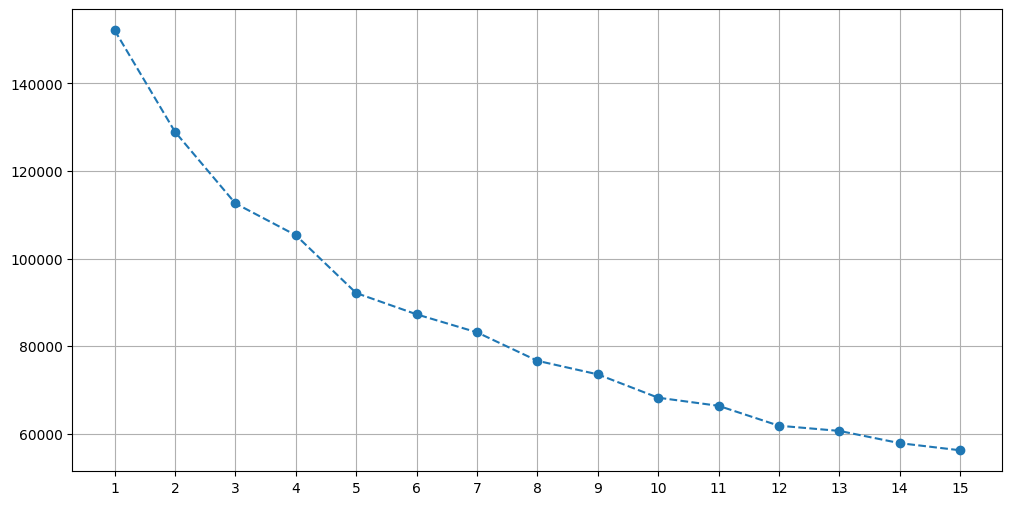

In [2]:
from sklearn.cluster import KMeans

wcss = []
k_range = range(1,16)
for i in k_range:
    kmeans = KMeans(n_clusters= i, init = 'k-means++', random_state = 42)
    kmeans.fit(df_scaled)
    wcss.append(kmeans.inertia_)

# Gráfico de cotovelo para visualização do número de clusters.
plt.figure(figsize=(12,6))
plt.plot(k_range, wcss, marker = 'o', linestyle='--')
plt.title =('Método do cotovelo ')
plt.xlabel = ("Nº de clusters")
plt.xticks(k_range)
plt.ylabel = ("Inércia")
plt.grid(True)
plt.show()

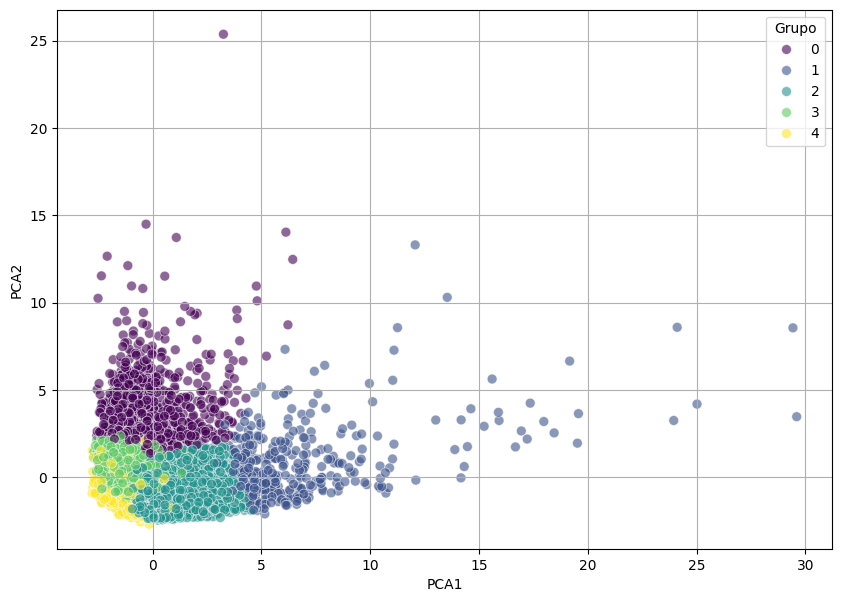

In [3]:
from sklearn.decomposition import PCA

# 1. Aplicar o K-Means Definitivo (K=5)
kmeans_final = KMeans(n_clusters= 5, init='k-means++', random_state=42)
clusters = kmeans_final.fit_predict(df_scaled)

# Adicionar a informação do cluster de volta ao DataFrame ORIGINAL (para analisarmos depois)
df['CLUSTER'] = clusters

# 2. Redução de Dimensionalidade (PCA) para Visualização 2D

pca = PCA(n_components=2)
principal_components = pca.fit_transform(df_scaled)

# Criar um DataFrame temporário só para o gráfico
df_pca = pd.DataFrame(data=principal_components, columns=['PCA1', 'PCA2'])
df_pca['CLUSTER'] = clusters

# 3. Plotar o Gráfico Final
plt.figure(figsize=(10,7))
sns.scatterplot(x='PCA1', y='PCA2', hue='CLUSTER', data=df_pca, palette='viridis', s=50, alpha=0.6)
plt.title = "Segmentação de Clientes (K-Means e= PCA)"
plt.xlabel = 'Componente Principal 1 (Maior Variância)'
plt.ylabel = 'Componente Principal 2 (Segunda Maior Variância)'
plt.legend(title='Grupo')
plt.grid(True)
plt.show()

### DBSCAN


DBSCAN: Encontrou 1 clusters com eps:1.5 e n_samples:20.
DBSCAN: Classificou 1894 pontos como Ruído (Outliers).
DBSCAN não conseguiu formar clusters suficientes para o Silhouette Score.


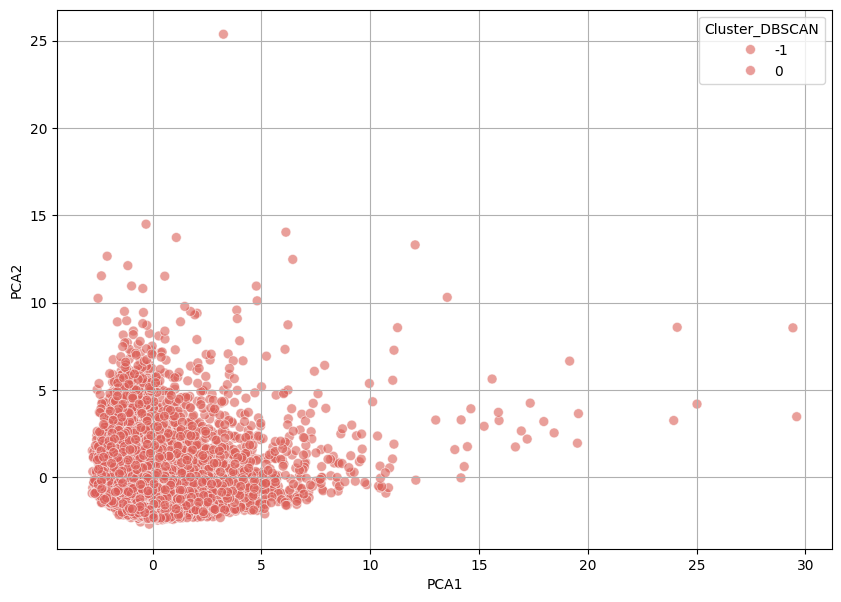

DBSCAN: Encontrou 2 clusters com eps:0.8 e n_samples:50.
DBSCAN: Classificou 6463 pontos como Ruído (Outliers).
Silhouette Score (DBSCAN): 0.3952


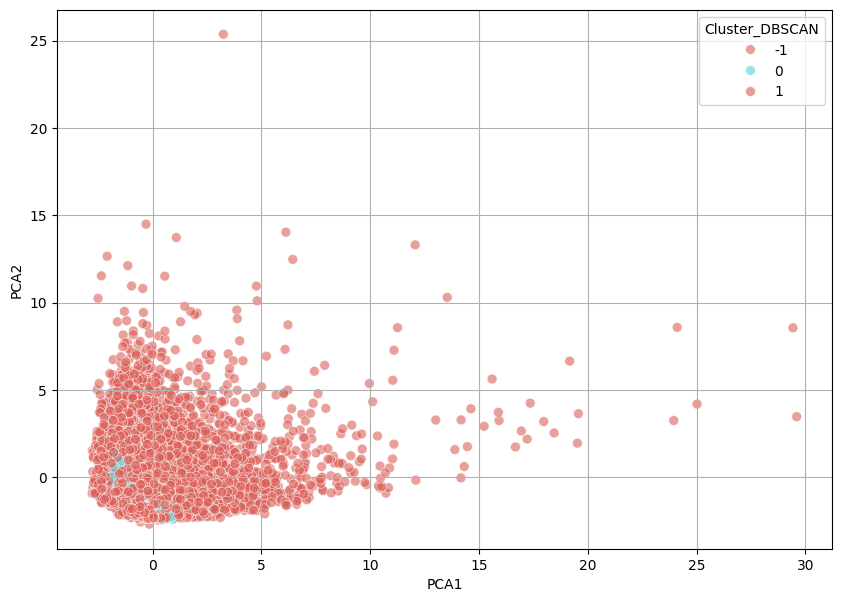

In [14]:
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score
import numpy as np



# Função para a
def plot_dbscan(eps,min_samples,df_scaled):

  dbscan = DBSCAN(eps=eps, min_samples=min_samples) # Tente 0.7 ou 0.8 para eps.
  dbscan_labels = dbscan.fit_predict(df_scaled)

  # O DBSCAN atribui o rótulo -1 ao ruído/outliers
  n_clusters = len(set(dbscan_labels)) - (1 if -1 in dbscan_labels else 0)
  n_noise = list(dbscan_labels).count(-1)

  print(f"DBSCAN: Encontrou {n_clusters} clusters com eps:{eps} e n_samples:{min_samples}.")
  print(f"DBSCAN: Classificou {n_noise} pontos como Ruído (Outliers).")

  # 2. Calcular o Silhouette Score (ignora o ruído)
  if n_clusters > 1:
      core_samples_mask = dbscan_labels != -1
      score_dbscan = silhouette_score(df_scaled[core_samples_mask], dbscan_labels[core_samples_mask])
      print(f"Silhouette Score (DBSCAN): {score_dbscan:.4f}")
  else:
      print("DBSCAN não conseguiu formar clusters suficientes para o Silhouette Score.")

  df_dbscan = pd.DataFrame(data=principal_components, columns=['PCA1', 'PCA2'])
  df_dbscan['Cluster_DBSCAN'] = dbscan_labels

  # 3. Plotar o Gráfico
  plt.figure(figsize=(10,7))
  sns.scatterplot(x='PCA1', y='PCA2', hue='Cluster_DBSCAN', data=df_dbscan, palette='hls',
    s=50,  alpha=0.6,legend="full")
  plt.title = 'Segmentação de Clientes (DBSCAN + PCA) - {n_clusters} Clusters'
  plt.xlabel='Componente Principal 1'
  plt.ylabel='Componente Principal 2'
  plt.grid(True)
  plt.show()

plot_dbscan(eps=1.5,min_samples=20,df_scaled=df_scaled)
plot_dbscan(eps=0.8,min_samples=50,df_scaled=df_scaled)

### Etapa 3: Interpretação dos Padrões

In [ ]:
# -- Análise a procura de identificar os grupos
perfil_clusters = df.groupby('CLUSTER').mean()

# -- Colunas mais importantes do dataset --
colunas_chave = ['BALANCE', 'PURCHASES', 'CASH_ADVANCE', 'CREDIT_LIMIT', 'PAYMENTS']

print("--- Médias dos Atributos por Cluster ---")
print(perfil_clusters[colunas_chave].sort_values(by='PURCHASES', ascending=False))

print("\nContagem de Clientes por Grupo:")
print(df['CLUSTER'].value_counts().sort_index())


*   GRUPO 3 E 4: MASSA ⇒ Tudo muito baixo
*   GRUPO 1: DISPERSÃO HORIZONTAL ⇒ Maior `PURCHASES` e `CREDIT_LIMIT`
*   GRUPO 0: DISPERSÃO VERTICAL ⇒ `CASH ADVANCE` alto demais = tomadores de empréstimo
*   GRUPO 2: TRANSIÇÃO

### Etapa 4: Comparação e Conclusão

Nessa etapa foi usado o __Silhoutte Score__, da biblioteca __scikit_learn__ para definir qual algoritmo
obteu um score mais alto em cima dos dados.

In [ ]:

agg_cluster = AgglomerativeClustering(n_clusters=5)
agg_labels = agg_cluster.fit_predict(df_scaled)

score_kmeans = silhouette_score(df_scaled, kmeans_final.labels_)
score_agg = silhouette_score(df_scaled, agg_labels)

print(f"Silhouette Score (K-Means com K=5): {score_kmeans:.4f}")
print(f"Silhouette Score (Agglomerative com K=5): {score_agg:.4f}")